In [1]:
%matplotlib widget
import nest
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt
from nest import raster_plot


              -- N E S T --
  Copyright (C) 2004 The NEST Initiative

 Version: 3.7.0
 Built: May 24 2024 10:11:53

 This program is provided AS IS and comes with
 NO WARRANTY. See the file LICENSE for details.

 Problems or suggestions?
   Visit https://www.nest-simulator.org

 Type 'nest.help()' to find out more about NEST.



In [2]:
class LineMaze():
    '''
    The line maze consists of a single linear track with a reward
    zone at each end. The track is oriented along the x-axis.
    '''
    def __init__(self,N,L = 40):
        self.N = N
        self.L = L

        self.x = np.linspace(0,L,N)
        self.y = np.zeros(N)

        # reward zone x and y
        self.x_rz = np.array([0,L])
        self.y_rz = np.array([0,0])

        # the left and right trajectories
        self.x_left = np.zeros(N)
        self.y_left = np.zeros(N)
        self.x_right = np.zeros(N)
        self.y_right = np.zeros(N)

        self.x_left = np.linspace(0,-L/2,N)
        self.y_left = np.zeros(N)

        self.x_right = np.linspace(0,L/2,N)
        self.y_right = np.zeros(N)

    def plot(self):
        plt.plot(self.x,self.y,'k.')
        plt.plot(self.x_rz,self.y_rz,'r.')
        plt.axis('equal')
        plt.show()


def gen_traj(maze,N_trials,p_correct,speed=20):
    '''Generate a set of trajectories through the maze. The
    trajectories are generated by a random walk with a probability
    of turning left or right at each step. The probability of
    turning left or right is determined by the p_correct parameter.

    Go from the stem to the reward zone, passing through each
    node on the maze

    Speed is the speed of the mouse in cm/s
    '''
    # generate a sequence of correct and incorrect trials
    correct = np.random.rand(N_trials) < p_correct

    # generate a sequence of left and right turns based on correct
    # trials being the OPPOSITE of the preceeding trial. Left is -1 and right is 1
    first_turn = np.random.rand() < 0.5
    turns = np.zeros(N_trials)
    turns[0] = -1 if first_turn else 1
    for i in range(1,N_trials):
        if correct[i]:
            turns[i] = -turns[i-1]
        else:
            turns[i] = turns[i-1]

    # assign turns to the outcomes
    x = []
    y = []

    for i in range(N_trials):
        if turns[i] == -1:
            x.append(maze.x_left)
            y.append(maze.y_left)
        else:
            x.append(maze.x_right)
            y.append(maze.y_right)
    # flatten the arrays
    x = np.array(x).flatten()
    y = np.array(y).flatten()

    # calculate the time it takes to traverse the maze
    # get the physical distance tranvelled of one trial
    trial_length = np.sqrt((maze.x_left[0]-maze.x_left[-1])**2 + (maze.y_left[0]-maze.y_left[-1])**2)
    # the total time on the maze is the trial length divided by the speed 
    # times the number of trials
    t = np.linspace(0,N_trials*trial_length/speed,len(x))
    return t,x,y

def firing_place_cell_linear(t,x,center_x,L,sigma=7,rmax=20):
    '''Generate a place cell firing rate based on the position of the
    animal in the maze. The firing rate is a gaussian centered at the
    center_x position of the place cell. We ignore the center_y and y maze. 
    The firing rate is scaled by the distance from the center of the place field.

    center_x is the x position of the place field
    L is the maze length total
    sigma is the standard deviation of the gaussian

    There is also a theta-precession effect that is multiplied by the gaussian
    firing rate. This effect is a sinusoidal modulation of the firing rate with 
    a term for phase-precession.
    '''
    x_t = interpolate.interp1d(t,x,kind='linear',fill_value='extrapolate')
    # calculate the distance from the center of the place field
    # calculate the firing rate
    Q = sigma

    return lambda t: rmax*(np.exp(-((x_t(t)-center_x)**2)/(2*sigma**2)))*(np.cos(np.pi*7*t + (np.sign(center_x)*(x_t(t)-center_x-sigma)*np.pi/Q)))

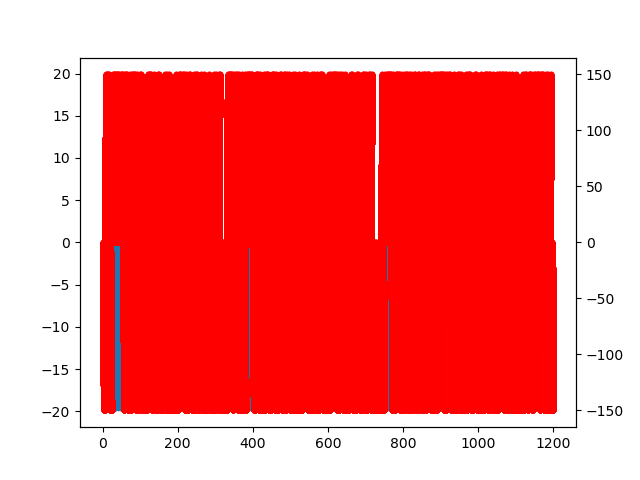

In [12]:
L_maze = 300
maze = LineMaze(3600,L=L_maze)
t,x,y = gen_traj(maze,400,0.5,50)
r = firing_place_cell_linear(t,x,30,L_maze)

plt.close('all')
plt.figure()
plt.plot(t,r(t))
plt.twinx()
plt.plot(t,x,'.r')
plt.show()

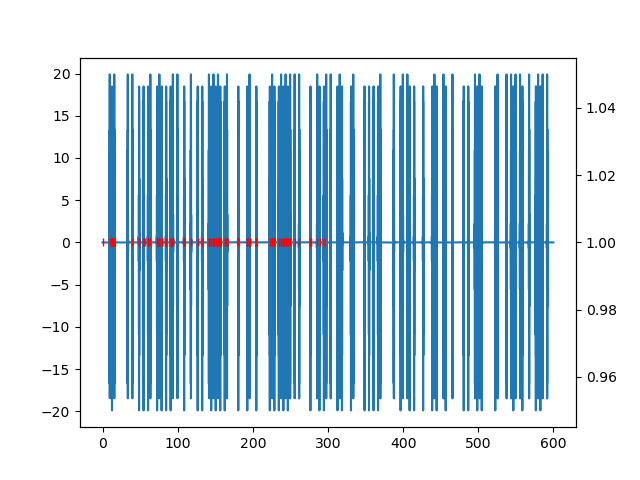

In [5]:
def accept_reject_spike(t0,tmax,r,r_max=20):
    t_spike = []
    t_spike.append(t0)
    t = 0
    while t <= tmax:
        # draw spike at the max rate
        t = t + np.random.exponential(1/r_max)

        # with probability r(t) / r_max, keep the spike
        if np.random.rand() < r(t) / r_max:
            t_spike.append(t0 + t)

    return np.array(t_spike)

s_times = accept_reject_spike(0,300,r)
plt.close('all')
plt.figure()
plt.plot(t,r(t))
plt.twinx()
plt.plot(s_times,np.ones_like(s_times),'|r')
plt.show()

**Exploration phase**

Network properties:
Using the basic structure of the model specified in [1] parameterized as in [2], the cell types in each region are

CA3: 1250 pyr, 100 interneurons

CA1: 1250 pyr, 100 interneurons

Furthermore, 10% of each CA3 and CA1 pyr cells are place cells and will be clamped to place-field like activity during learning, $\lambda_i(t)$. The remaining 90% of cells will be clamped to homogeneous Poisson processes with background rate of 0.1 Hz.

All pyr->pyr connections will be first tuned with STDP as in [1,2]. We accomplish this with NEST's `parrot_neuron` so that we can clamp its firing to a pre-specified spike timing sequence delivered to port 0. The remaining port 1 will be used to recieve spikes that are not repeated, but used in the standard STDP rule. 

Note, since the STDP rule only concerns the spike times of pyr cells, we can ignore both the other cell types AND the neurons' internal dynamics (since its spiking in clamped to a an external driver).

References

[1] Ecker, András, et al. "Hippocampal sharp wave-ripples and the associated sequence replay emerge from structured synaptic interactions in a network model of area CA3." Elife 11 (2022): e71850.

[2] Liu, Can, et al. "Associative and predictive hippocampal codes support memory-guided behaviors." Science 382.6668 (2023): eadi8237.

In [13]:
# Create CA3 and CA1 populations of parrot neurons
nest.ResetKernel()
nest.local_num_threads = 8
t_sim = 1200

N_pyr = 1250
CA3_pyr = nest.Create("parrot_neuron", N_pyr)
CA1_pyr = nest.Create("parrot_neuron", N_pyr)
nest.SetStatus(CA3_pyr, {"tau_minus": 62.5})
nest.SetStatus(CA1_pyr, {"tau_minus": 40})

# make the clamped rates to assign to cells
N_generators = int(np.floor(N_pyr*0.3))
place_cell_spikes_CA3 = nest.Create("spike_generator", N_generators)
place_cell_spikes_CA1 = nest.Create("spike_generator", N_generators)

def assign_spikes_to_pf_generator(pf,generator):
    r = firing_place_cell_linear(t,x,pf,L_maze,7)
    # draw spikes from the rate
    s_times = accept_reject_spike(0,t_sim,r)
    nest.SetStatus(generator, {"spike_times": 1000*s_times+0.1,"allow_offgrid_times": True,"precise_times": False})

    return

# for each generator, draw a random place field on the maze and assign the rate generated
# along a trajectory to the generator
pf_CA3 = np.sort(np.random.uniform(-L_maze/2,L_maze/2,N_generators))
for pf,generator in zip(pf_CA3,place_cell_spikes_CA3):
    assign_spikes_to_pf_generator(pf,generator)

pf_CA1 = np.sort(np.random.uniform(-L_maze/2,L_maze/2,N_generators))
for pf,generator in zip(pf_CA1,place_cell_spikes_CA1):
    assign_spikes_to_pf_generator(pf,generator)

# generate the rest of the generators with random rates
silent_cell_spikes = nest.Create("poisson_generator")
nest.SetStatus(silent_cell_spikes, {"rate": 0.1})

# connect the generators to the CA3 and CA1 populations
nest.Connect(place_cell_spikes_CA3, CA3_pyr[0:N_generators], syn_spec={'weight': 1.0,'receptor_type':0}, conn_spec={'rule': 'one_to_one'})
nest.Connect(silent_cell_spikes, CA3_pyr[N_generators:], syn_spec={'weight': 1.0,'receptor_type':0}, conn_spec={'rule': 'all_to_all'})
nest.Connect(place_cell_spikes_CA1, CA1_pyr[0:N_generators], syn_spec={'weight': 1.0,'receptor_type':0}, conn_spec={'rule': 'one_to_one'})
nest.Connect(silent_cell_spikes, CA1_pyr[N_generators:], syn_spec={'weight': 1.0,'receptor_type':0}, conn_spec={'rule': 'all_to_all'})

# define a STDP synapse
weight_recorder = nest.Create("weight_recorder")
# divide lambda by Wmax to scale everything to [0,1], which is then rescaled by Wmax in the synapse
nest.CopyModel("stdp_synapse", "CA3_to_CA3",{"alpha": -1.0, "lambda": 0.08/40, "tau_plus": 62.5,"mu_plus":0,"mu_minus":0, "Wmax": 40.0,"weight_recorder": weight_recorder})
nest.CopyModel("stdp_synapse", "CA3_to_CA1",{"alpha": 0.4, "lambda": 0.8/40, "tau_plus": 20.0,"mu_plus":0,"mu_minus":0, "Wmax": 40.0,"weight_recorder": weight_recorder})

# connect the CA3 and CA1 populations with the STDP synapse
nest.Connect(CA3_pyr, CA3_pyr, syn_spec={'synapse_model':"CA3_to_CA3",'receptor_type':1,
                                         'weight':0.3*nest.random.lognormal(0,1)}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})
nest.Connect(CA3_pyr, CA1_pyr, syn_spec={'synapse_model':"CA3_to_CA1",'receptor_type':1,
                                         'weight':0.7*nest.random.lognormal(0,1)}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})

# monitor the spiking activity of the CA3 and CA1 populations
spike_detector = nest.Create("spike_recorder")
nest.Connect(CA3_pyr, spike_detector)
nest.Connect(CA1_pyr, spike_detector)
nest.Simulate(t_sim*1000)


Jul 27 18:26:33 NodeManager::prepare_nodes [Info]: 
    Preparing 8524 nodes for simulation.

Jul 27 18:26:33 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 8524
    Simulation time (ms): 1.2e+06
    Number of OpenMP threads: 8
    Not using MPI

Jul 27 18:28:31 SimulationManager::run [Info]: 
    Simulation finished.


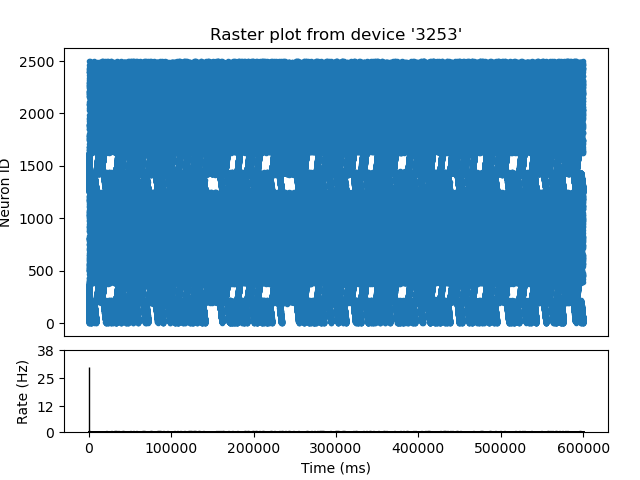

In [7]:
from nest import raster_plot

plt.close('all')
raster_plot.from_device(spike_detector,hist=True, hist_binwidth=10.0)

**Post-exploration** 

Now that the pyramidal cell weight matrix has been tuned, we can "query" its spontaneous activity by using it in a network driven by noise.

In [14]:
conn_CA3_to_CA3 = nest.GetConnections(CA3_pyr,CA3_pyr).get(['source','target','weight'])
conn_CA3_to_CA1 = nest.GetConnections(CA3_pyr,CA1_pyr).get(['source','target','weight'])

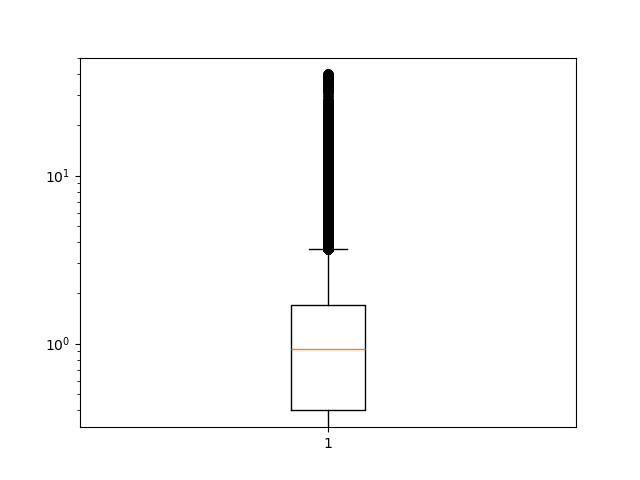

In [15]:
plt.close('all')
plt.figure()
plt.boxplot(conn_CA3_to_CA1['weight'])
plt.yscale('log')
plt.show()

In [18]:
# making a new newtork
nest.ResetKernel()
nest.SetKernelStatus({"resolution": 0.1})

# Create CA3 and CA1 populations of adaptive exponential integrate-and-fire neurons
N_pyr = 1250
tau_decay_pyr_e = 9.0
tau_rise_pyr_e = 1.0
tau_decay_pyr_i = 3.0
tau_rise_pyr_i = 0.3
tau_decay_gc = 5.4
tau_rise_gc = 0.65
t_p_pyr_e = (tau_decay_pyr_e*tau_rise_pyr_e)/(tau_decay_pyr_e-tau_rise_pyr_e)*(np.log(tau_decay_pyr_e/tau_rise_pyr_e))
t_p_pyr_i = (tau_decay_pyr_i*tau_rise_pyr_i)/(tau_decay_pyr_i-tau_rise_pyr_i)*(np.log(tau_decay_pyr_i/tau_rise_pyr_i))
t_p_gc = (tau_decay_gc*tau_rise_gc)/(tau_decay_gc-tau_rise_gc)*(np.log(tau_decay_gc/tau_rise_gc))
A_pyr_e = 1#np.exp(-t_p_pyr_e/tau_decay_pyr_e) - np.exp(-t_p_pyr_e/tau_rise_pyr_e)
A_pyr_i = 1#np.exp(-t_p_pyr_i/tau_decay_pyr_i) - np.exp(-t_p_pyr_i/tau_rise_pyr_i)
A_gc = 1#np.exp(-t_p_gc/tau_decay_gc) - np.exp(-t_p_gc/tau_rise_gc)

pyr_spec = {'C_m':180,'g_L':4.3,'E_L':-75,'Delta_T':4.23,'V_th':-24,'V_peak':-3.25,'V_reset':-29.7,'t_ref':5.9,
            'tau_w':84.93,'a':-0.27,'b':206.84,'E_rev':[0,-90,0],
            'tau_rise':[tau_rise_pyr_e,tau_rise_pyr_i,tau_rise_gc],'tau_decay':[tau_decay_pyr_e,tau_decay_pyr_i,tau_decay_gc]}
CA3_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
CA1_pyr_aeif = nest.Create("aeif_cond_beta_multisynapse", N_pyr, pyr_spec)
# make interneurons in CA3 and CA1
N_int = 250
int_spec = {'C_m':118,'g_L':7.5,'E_L':-74,'Delta_T':4.6,'V_th':-57.7,'V_peak':-34.78,'V_reset':-65,'t_ref':1,
            'tau_w':178.58,'a':3.05,'b':0.91,'E_rev':[0,-90],
            'tau_rise':[tau_rise_pyr_e,tau_rise_pyr_i],'tau_decay':[tau_decay_pyr_e,tau_decay_pyr_i]}
CA3_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)
CA1_int_aeif = nest.Create("aeif_cond_beta_multisynapse", N_int, int_spec)

# connect the CA3 and CA1 populations with static synapses with the weights learned from the previous simulation
# the order of nodes is presevered since the neurons are created in the same order
nest.Connect(conn_CA3_to_CA3['source'], conn_CA3_to_CA3['target'], 
             'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': A_pyr_e*np.array(conn_CA3_to_CA3['weight']), 'receptor_type':1})
nest.Connect(conn_CA3_to_CA1['source'], conn_CA3_to_CA1['target'], 
             'one_to_one', syn_spec={'synapse_model':'static_synapse','weight': A_pyr_e*np.array(conn_CA3_to_CA1['weight']), 'receptor_type':1})

# now we wire pyr to int with a probability of 0.1
nest.Connect(CA3_pyr_aeif, CA3_int_aeif, syn_spec={'weight': A_pyr_e*0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})
nest.Connect(CA1_pyr_aeif, CA1_int_aeif, syn_spec={'weight': A_pyr_e*0.85, 'receptor_type':1}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.1,'allow_autapses': False})

# connect the interneurons with each other with a probability of 0.25
nest.Connect(CA3_int_aeif, CA3_int_aeif, syn_spec={'weight': A_pyr_i*5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})
nest.Connect(CA1_int_aeif, CA1_int_aeif, syn_spec={'weight': A_pyr_i*5, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})

# and the interneurons to the pyramidal cells with a probability of 0.25
nest.Connect(CA3_int_aeif, CA3_pyr_aeif, syn_spec={'weight': A_pyr_i*0.65, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})
nest.Connect(CA1_int_aeif, CA1_pyr_aeif, syn_spec={'weight': A_pyr_i*0.65, 'receptor_type':2}, conn_spec={'rule': 'pairwise_bernoulli', 'p': 0.25,'allow_autapses': False})

# create a stim to drive all the CA3 pyramidal cells
stim = nest.Create("poisson_generator",1,{'rate': 15.0})
nest.Connect(stim, CA3_pyr_aeif, syn_spec={'weight': A_gc*25.0, 'receptor_type':3}, conn_spec={'rule': 'all_to_all'})

# monitor the spiking activity of the CA3 and CA1 populations
spike_detector = nest.Create("spike_recorder")
nest.Connect(CA3_pyr_aeif, spike_detector)
nest.Connect(CA1_pyr_aeif, spike_detector)
nest.Connect(CA3_int_aeif, spike_detector)
nest.Connect(CA1_int_aeif, spike_detector)
nest.Simulate(5000)


Jul 27 18:38:43 SimulationManager::set_status [Info]: 
    Temporal resolution changed from 0.1 to 0.1 ms.

Jul 27 18:38:43 NodeManager::prepare_nodes [Info]: 
    Preparing 3002 nodes for simulation.

Jul 27 18:38:43 SimulationManager::start_updating_ [Info]: 
    Number of local nodes: 3002
    Simulation time (ms): 5000
    Number of OpenMP threads: 1
    Not using MPI

Jul 27 18:39:32 SimulationManager::run [Info]: 
    Simulation finished.


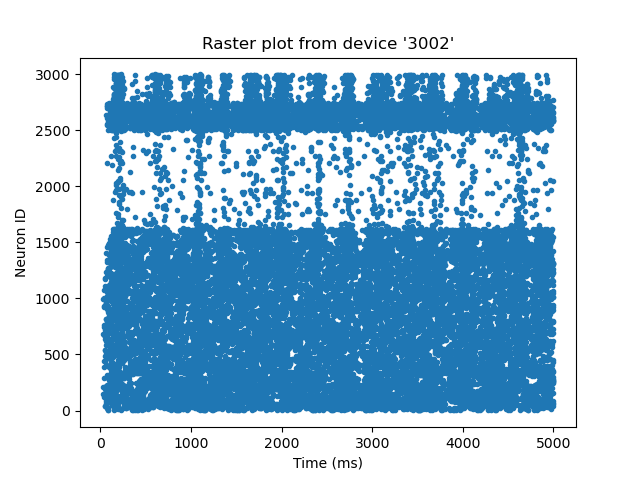

In [19]:
plt.close('all')
raster_plot.from_device(spike_detector,hist=False)
#plt.ylim([0,125])